In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import shutil
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorboard
import os
import pandas as pd
import math
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import Xception
import cv2
import seaborn as sns

In [2]:
# the data is structured into two groups
# Cancer : Mel, BCC and SCC - the three cancer categories
# NonCancer :other 4 classes : AK, BKL, DF, VASC, NV
# Using class weights
# Applying random augmentations as before
# Applying resnet preprocess_input pre processing to training, validation and testing data

In [3]:
batch_size = 32
img_height = 128
img_width = 128

In [4]:
# inhibit graphics card runs out of memory
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [5]:
dataset = 'Data/Binary_Can_Noncan/train'
dataset_path = os.listdir(dataset)

print (dataset_path)  #what kinds of classes are in this dataset

print("Types of classes labels found: ", len(dataset_path))

['cancer', 'noncancer']
Types of classes labels found:  2


In [6]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# create a directory to save the files
create_dir("models")

In [7]:
# load the augmented data from the local data directory:

train_dir = "Data/Binary_Can_Noncan/train"
test_dir = "Data/Binary_Can_Noncan/test"
valid_dir = "Data/Binary_Can_Noncan/valid"

datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2,rotation_range=30,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        horizontal_flip=True, vertical_flip=True, data_format="channels_last",
                                        dtype=tf.float32, preprocessing_function=preprocess_input)
                                        # The imported data will be normalized here.

test_datagen = ImageDataGenerator(rescale=1./255,data_format="channels_last", dtype=tf.float32,
                         preprocessing_function=preprocess_input)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle = True,
    seed=123) # set as training data

validation_generator =datagen.flow_from_directory(
    valid_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle = True,
    seed=123) # set as validation data

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle = True,
    seed=123) # set as testing data

Found 17728 images belonging to 2 classes.
Found 3796 images belonging to 2 classes.
Found 3799 images belonging to 2 classes.


In [8]:
# Define some model parameters
input_shape = (img_height, img_width, 3)
training_shape = (img_height,img_width,3)

optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

epochs = 100

Metrics = ["accuracy",
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc')]

learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy', patience=5, verbose=1, factor=0.5, min_lr=0.0000001)
early_stopping_monitor = EarlyStopping(patience=10, monitor='accuracy', restore_best_weights=True)
checkpointer = ModelCheckpoint(filepath="Xception_weights_CW_P_can_noncan.h5", verbose=0, monitor='accuracy', save_best_only=True, save_weights_only=False, mode ='auto', save_freq='epoch')

In [9]:
from sklearn.utils import class_weight
weights = class_weight.compute_class_weight(class_weight= 'balanced', classes= np.unique(train_generator.classes), y= train_generator.classes)
class_weights = dict(zip(np.unique(train_generator.classes), weights))
#weights = array([2.80063191, 0.6086658 ])

In [10]:
class_weights

{0: 1.4947723440134908, 1: 0.7513137819969486}

In [11]:
# Defining an Xception model

base_model = Xception(include_top=False,weights='imagenet',input_shape = training_shape)

XCeptionmodel = base_model.output
XCeptionmodel = Flatten()(XCeptionmodel)

XCeptionmodel = BatchNormalization()(XCeptionmodel)
XCeptionmodel = Dense(128, activation='relu')(XCeptionmodel)
XCeptionmodel = Dropout(0.2)(XCeptionmodel)

XCeptionmodel = BatchNormalization()(XCeptionmodel)
XCeptionoutput = Dense(2, activation = 'sigmoid')(XCeptionmodel)
XCeptionmodel = Model(inputs=base_model.input, outputs=XCeptionoutput)

model = XCeptionmodel

for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=Metrics)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [12]:
history = model.fit(
    train_generator,
    epochs = epochs,
    steps_per_epoch=train_generator.samples//batch_size,
    validation_data = validation_generator,
    validation_steps=validation_generator.samples//batch_size,
    callbacks=[learning_rate_reduction,early_stopping_monitor, checkpointer], class_weight=class_weights)

Epoch 1/100
554/554 [==============================] - 355s 641ms/step - loss: 0.5521 - accuracy: 0.7216 - precision: 0.7201 - recall: 0.7151 - auc: 0.7877 - val_loss: 0.6900 - val_accuracy: 0.6653 - val_precision: 0.6651 - val_recall: 0.6642 - val_auc: 0.7118
Epoch 2/100
554/554 [==============================] - 234s 423ms/step - loss: 0.4962 - accuracy: 0.7577 - precision: 0.7578 - recall: 0.7570 - auc: 0.8344 - val_loss: 0.4768 - val_accuracy: 0.7577 - val_precision: 0.7593 - val_recall: 0.7519 - val_auc: 0.8497
Epoch 3/100
554/554 [==============================] - 237s 428ms/step - loss: 0.4764 - accuracy: 0.7675 - precision: 0.7688 - recall: 0.7658 - auc: 0.8494 - val_loss: 0.6330 - val_accuracy: 0.6880 - val_precision: 0.6864 - val_recall: 0.6925 - val_auc: 0.7688
Epoch 4/100
554/554 [==============================] - 235s 424ms/step - loss: 0.4597 - accuracy: 0.7755 - precision: 0.7769 - recall: 0.7738 - auc: 0.8601 - val_loss: 0.4376 - val_accuracy: 0.7860 - val_precision: 0.

In [13]:
model.save("models/model_Xception_CW_P_can_noncan.h5")

In [12]:
#model = tf.keras.models.load_model("models/model_Xception_CW_P_can_noncan.h5")

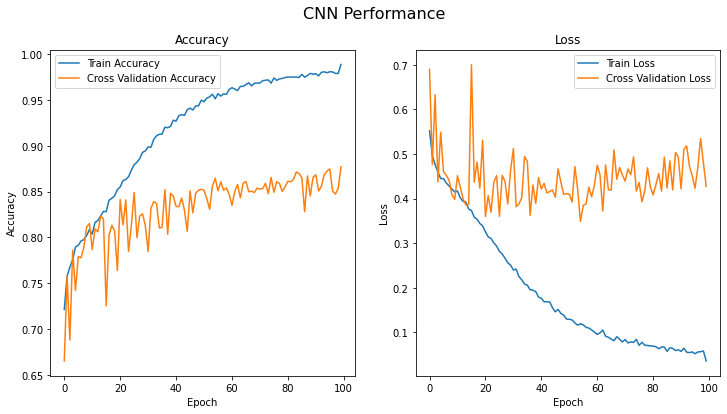

In [14]:
# visualize the loss & accuracy with the train and crossvalidation
f, (f1, f2) = plt.subplots(1, 2, figsize=(12, 6))
f.suptitle('CNN Performance', fontsize=16)

f1.plot(history.history['accuracy'], label='Train Accuracy')
f1.plot(history.history['val_accuracy'], label='Cross Validation Accuracy')
f1.set_ylabel('Accuracy')
f1.set_xlabel('Epoch')
f1.set_title('Accuracy')
f1.legend(loc="best")

f2.plot(history.history['loss'], label='Train Loss')
f2.plot(history.history['val_loss'], label='Cross Validation Loss')
f2.set_ylabel('Loss')
f2.set_xlabel('Epoch')
f2.set_title('Loss')
f2.legend(loc="best")

In [ ]:
res = model.evaluate(test_generator)

In [18]:
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(test_generator, test_generator.samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
#target_names = ['ak', 'bcc', 'bkl', 'df', 'mel','nv', 'scc', 'vasc']
target_names = ['Cancer', 'Non Cancer']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[ 352  918]
 [ 789 1740]]
Classification Report
              precision    recall  f1-score   support

      Cancer       0.31      0.28      0.29      1270
  Non Cancer       0.65      0.69      0.67      2529

    accuracy                           0.55      3799
   macro avg       0.48      0.48      0.48      3799
weighted avg       0.54      0.55      0.54      3799



In [19]:
from sklearn.metrics import accuracy_score
print(accuracy_score(test_generator.classes, y_pred))

0.5506712292708608


In [20]:
from sklearn.metrics import balanced_accuracy_score
print(balanced_accuracy_score(test_generator.classes, y_pred))

0.48259216708231756


In [ ]:
# loading a new balanced test data which has around same number of images for both cancer and non cancer class

In [22]:
test_dir = "Data/Binary_Can_Noncan/test_bal"

test_datagen = ImageDataGenerator(rescale=1./255,data_format="channels_last", dtype=tf.float32,
                         preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle = True,
    seed=123,) # set as testing data

Found 2540 images belonging to 2 classes.


In [23]:
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(test_generator, test_generator.samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
#target_names = ['ak', 'bcc', 'bkl', 'df', 'mel','nv', 'scc', 'vasc']
target_names = ['Cancer', 'Non-Cancer']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[517 753]
 [538 732]]
Classification Report
              precision    recall  f1-score   support

      Cancer       0.49      0.41      0.44      1270
  Non-Cancer       0.49      0.58      0.53      1270

    accuracy                           0.49      2540
   macro avg       0.49      0.49      0.49      2540
weighted avg       0.49      0.49      0.49      2540



In [24]:
from sklearn.metrics import accuracy_score
print(accuracy_score(test_generator.classes, y_pred))

0.49173228346456693


In [25]:
from sklearn.metrics import balanced_accuracy_score
print(balanced_accuracy_score(test_generator.classes, y_pred))

0.49173228346456693


(True postive):  517
 (False Positives):  753
(False Negatives):  538
 (True Negative):  732
total malignant:  1270


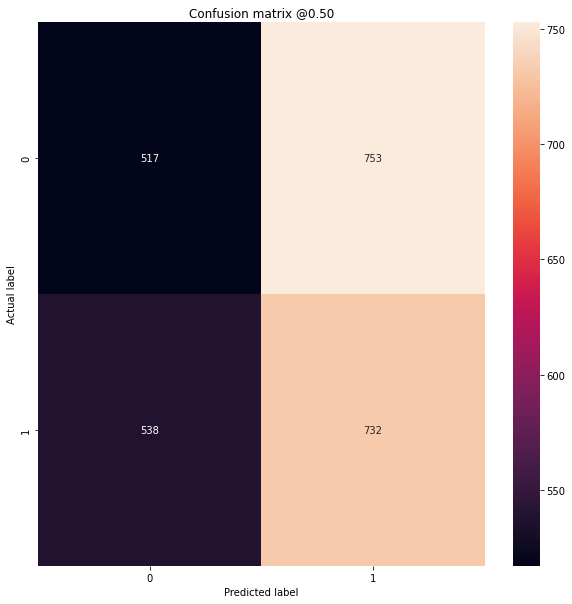

In [26]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('(True postive): ', cm[0][0])
    print(' (False Positives): ', cm[0][1])
    print('(False Negatives): ', cm[1][0])
    print(' (True Negative): ', cm[1][1])
    print('total malignant: ', np.sum(cm[1]))

plot_cm(test_generator.classes, y_pred)